In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import os
import random
from empirical_data import *
from optimized_random_response import *
from randomized_response import *
from repetitive_optimizer import *
from synthetic_dataset import *
import seaborn as sns

IS_SYNTHETIC = True
# IS_UNIFORM = 
FILE_LOCATION = "/Users/sandarujayawardana/Downloads/celeba_anno/list_attr_celeba.txt"
TEST_AMOUNT = 0.7
MAX_UTILITY_ERR_ALOWED = 0.2

Attr_list = ["Male", "Attractive"] #, '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive'] #, 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair']#, 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'] # ["Male", "Big_Nose"] #, "Gray_Hair", "Big_Nose", "Smiling"] #, "Gray_Hair"]
error_cal_type = "l2" # ["0_1", "l1", "l2"]

alphabet_dict = {}
dict_attr_node = {}
read_data = []

def error_cal(actual, perturbed, err_type = "0_1"):
    if isinstance(actual, str):
        actual = list(alphabet_dict.keys()).index(actual)
        perturbed = list(alphabet_dict.keys()).index(perturbed)
    # print(actual, perturbed)
    if err_type == "0_1":
        return 0 if (actual == perturbed) else 1
    elif err_type == "l1":
        return abs((actual)-(perturbed)) # np.linalg.norm(((actual)-(perturbed)), 1)
    elif err_type == "l2":
        return ((actual)-(perturbed))**2 #np.linalg.norm(((actual)-(perturbed)), 2)
    else:
        assert(f"Unknown error type {err_type}")

# Reading txt
with open(FILE_LOCATION, 'r') as txt_file:
    no_of_lines = int(txt_file.readline())
    fields = txt_file.readline()

    for i, attr in enumerate(fields.split()):
      dict_attr_node[attr] = i+1
    print(dict_attr_node)
    print(dict_attr_node.keys())

    # Create alphabet
    for i in range(no_of_lines):
        rows = txt_file.readline().split()
        single_row = ""
        for j in Attr_list:
            single_row += " " + rows[dict_attr_node[j]]
        read_data.append(single_row)

for i in read_data:
    if i not in alphabet_dict.keys():
        alphabet_dict[i] = 1
    else:
        alphabet_dict[i] += 1

for key in alphabet_dict.keys():
    alphabet_dict[key] /= no_of_lines

prior_dist = np.array(list(alphabet_dict.values())) # np.ones(len(alphabet_dict))/len(alphabet_dict)# 

print(prior_dist, alphabet_dict)

TEST_LENGTH = int(TEST_AMOUNT * no_of_lines)
START_INDEX = random.randint(0, no_of_lines - TEST_LENGTH)# Starting index of test set
END_INDEX = START_INDEX + TEST_LENGTH - 1

{'5_o_Clock_Shadow': 1, 'Arched_Eyebrows': 2, 'Attractive': 3, 'Bags_Under_Eyes': 4, 'Bald': 5, 'Bangs': 6, 'Big_Lips': 7, 'Big_Nose': 8, 'Black_Hair': 9, 'Blond_Hair': 10, 'Blurry': 11, 'Brown_Hair': 12, 'Bushy_Eyebrows': 13, 'Chubby': 14, 'Double_Chin': 15, 'Eyeglasses': 16, 'Goatee': 17, 'Gray_Hair': 18, 'Heavy_Makeup': 19, 'High_Cheekbones': 20, 'Male': 21, 'Mouth_Slightly_Open': 22, 'Mustache': 23, 'Narrow_Eyes': 24, 'No_Beard': 25, 'Oval_Face': 26, 'Pale_Skin': 27, 'Pointy_Nose': 28, 'Receding_Hairline': 29, 'Rosy_Cheeks': 30, 'Sideburns': 31, 'Smiling': 32, 'Straight_Hair': 33, 'Wavy_Hair': 34, 'Wearing_Earrings': 35, 'Wearing_Hat': 36, 'Wearing_Lipstick': 37, 'Wearing_Necklace': 38, 'Wearing_Necktie': 39, 'Young': 40}
dict_keys(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_M

In [2]:
# import warnings

# warnings.filterwarnings("ignore")

In [3]:
# Initialize RR
rr_mechanism = Randomized_Response(len(alphabet_dict.keys()), list(alphabet_dict.keys()))

def generate_normalized_err_matrix(dimension, err_type = "0_1"):
    value_array = np.arange(dimension)
    normalized_err_matrix = np.zeros((dimension, dimension))
    for i in value_array:
        for j in value_array:
            normalized_err_matrix[i][j] = error_cal(actual=i, perturbed=j, err_type=err_type)
    normalized_err_matrix = normalized_err_matrix/np.max(normalized_err_matrix)
    print(normalized_err_matrix, np.max(normalized_err_matrix))
    return normalized_err_matrix

# generate_normalized_err_matrix(8)

# Initialize optimize RR
optimal_rr_mechanism = Optimized_Randomized_Response(prior_dist = prior_dist, STATE_COUNT = len(alphabet_dict.keys()), INPUT_ALPHABET = list(alphabet_dict.keys()), normalized_objective_err_matrix = generate_normalized_err_matrix(len(alphabet_dict.keys()), err_type=error_cal_type), 
                 TOLERANCE_MARGIN = 0.01, APPROXIMATION = "LINEAR", solver = "MOSEK", is_kl_div = True, ALPHA=0.01)

[[0.         0.11111111 0.44444444 1.        ]
 [0.11111111 0.         0.11111111 0.44444444]
 [0.44444444 0.11111111 0.         0.11111111]
 [1.         0.44444444 0.11111111 0.        ]] 1.0


0.0
expected_error_matrix [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[0.27067261 0.12911383 0.20977728 0.51266295]
[1.08269044 0.51645533 0.83910911 2.05065178]
sum_row_values [1.08269044 0.51645533 0.83910911 2.05065178]
X_new.value [1.00000e-06 8.99997e-01 1.00000e-06 1.00000e-06]
matrix [[1.00000e-06 8.99997e-01 1.00000e-06 1.00000e-06]
 [1.00000e-06 8.99997e-01 1.00000e-06 1.00000e-06]
 [1.00000e-06 8.99997e-01 1.00000e-06 1.00000e-06]
 [1.00000e-06 8.99997e-01 1.00000e-06 1.00000e-06]]


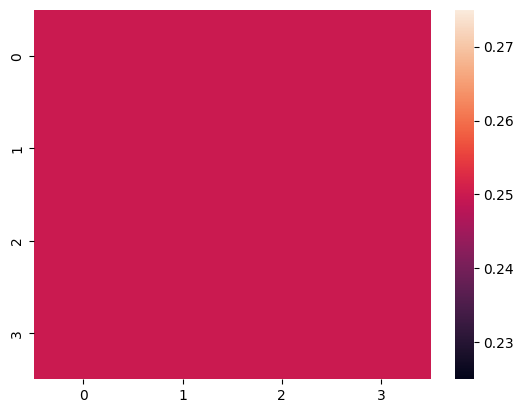

0.0
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
[[1.11111111e-06 9.99996667e-01 1.11111111e-06 1.11111111e-06]
 [1.11111111e-06 9.99996667e-01 1.11111111e-06 1.11111111e-06]
 [1.11111111e-06 9.99996667e-01 1.11111111e-06 1.11111111e-06]
 [1.11111111e-06 9.99996667e-01 1.11111111e-06 1.11111111e-06]]


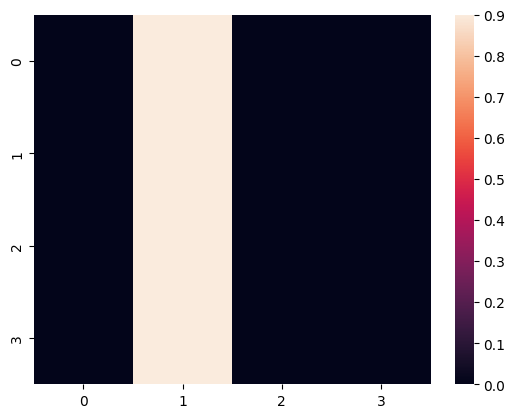

0.6
expected_error_matrix [[1.         0.54881164 0.54881164 0.54881164]
 [0.54881164 1.         0.54881164 0.54881164]
 [0.54881164 0.54881164 1.         0.54881164]
 [0.54881164 0.54881164 0.54881164 1.        ]]
[0.27067261 0.12911383 0.20977728 0.51266295]
[0.71631744 0.34169135 0.55516191 1.35672911]
sum_row_values [0.71631744 0.34169135 0.55516191 1.35672911]
X_new.value [0.15622992 0.59950376 0.59950376 0.15622992]
matrix [[0.15622992 0.32901464 0.32901464 0.0857408 ]
 [0.0857408  0.59950376 0.32901464 0.0857408 ]
 [0.0857408  0.32901464 0.59950376 0.0857408 ]
 [0.0857408  0.32901464 0.32901464 0.15622992]]


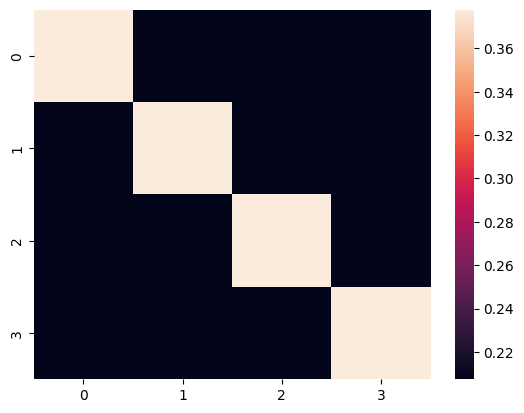

0.6
[[0.37786684 0.20737772 0.20737772 0.20737772]
 [0.20737772 0.37786684 0.20737772 0.20737772]
 [0.20737772 0.20737772 0.37786684 0.20737772]
 [0.20737772 0.20737772 0.20737772 0.37786684]]
[[0.1735888  0.36557182 0.36557182 0.09526755]
 [0.07794618 0.54500342 0.29910422 0.07794618]
 [0.07794618 0.29910422 0.54500342 0.07794618]
 [0.09526755 0.36557182 0.36557182 0.1735888 ]]


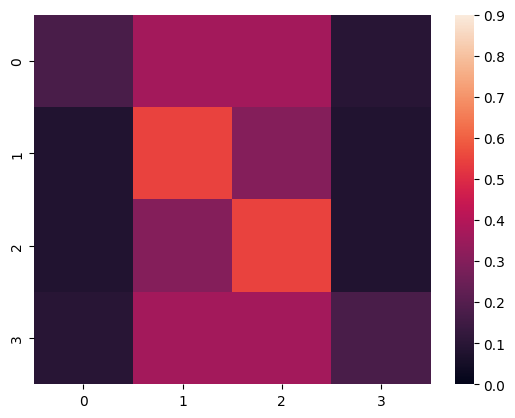

1.2
expected_error_matrix [[1.         0.30119421 0.30119421 0.30119421]
 [0.30119421 1.         0.30119421 0.30119421]
 [0.30119421 0.30119421 1.         0.30119421]
 [0.30119421 0.30119421 0.30119421 1.        ]]
[0.27067261 0.12911383 0.20977728 0.51266295]
[0.51524768 0.24577885 0.39932838 0.97589628]
sum_row_values [0.51524768 0.24577885 0.39932838 0.97589628]
X_new.value [0.42750834 0.71371089 0.42750834 0.42750834]
matrix [[0.42750834 0.21496559 0.12876304 0.12876304]
 [0.12876304 0.71371089 0.12876304 0.12876304]
 [0.12876304 0.21496559 0.42750834 0.12876304]
 [0.12876304 0.21496559 0.12876304 0.42750834]]


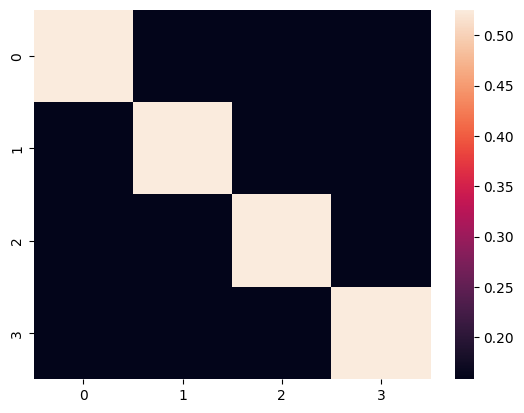

1.2
[[0.52532524 0.15822492 0.15822492 0.15822492]
 [0.15822492 0.52532524 0.15822492 0.15822492]
 [0.15822492 0.15822492 0.52532524 0.15822492]
 [0.15822492 0.15822492 0.15822492 0.52532524]]
[[0.47500926 0.23885065 0.14307004 0.14307004]
 [0.11705731 0.64882808 0.11705731 0.11705731]
 [0.14307004 0.23885065 0.47500926 0.14307004]
 [0.14307004 0.23885065 0.14307004 0.47500926]]


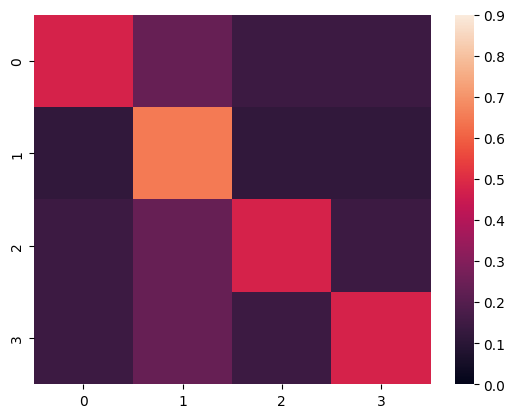

1.7999999999999998
expected_error_matrix [[1.         0.16529889 0.16529889 0.16529889]
 [0.16529889 1.         0.16529889 0.16529889]
 [0.16529889 0.16529889 1.         0.16529889]
 [0.16529889 0.16529889 0.16529889 1.        ]]
[0.27067261 0.12911383 0.20977728 0.51266295]
[0.40489825 0.19314095 0.31380513 0.76689079]
sum_row_values [0.40489825 0.19314095 0.31380513 0.76689079]
X_new.value [0.60164584 0.60164584 0.60164584 0.60164584]
matrix [[0.60164584 0.09945139 0.09945139 0.09945139]
 [0.09945139 0.60164584 0.09945139 0.09945139]
 [0.09945139 0.09945139 0.60164584 0.09945139]
 [0.09945139 0.09945139 0.09945139 0.60164584]]


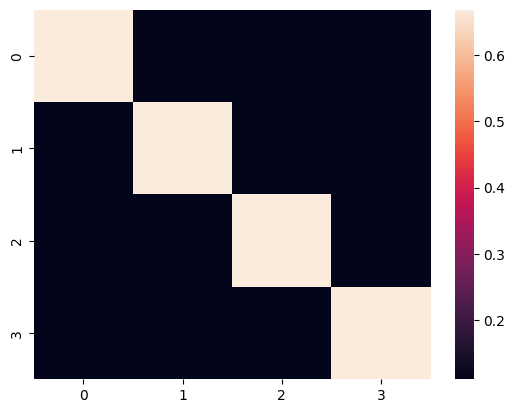

1.7999999999999998
[[0.66849537 0.11050154 0.11050154 0.11050154]
 [0.11050154 0.66849537 0.11050154 0.11050154]
 [0.11050154 0.11050154 0.66849537 0.11050154]
 [0.11050154 0.11050154 0.11050154 0.66849537]]
[[0.66849537 0.11050154 0.11050154 0.11050154]
 [0.11050154 0.66849537 0.11050154 0.11050154]
 [0.11050154 0.11050154 0.66849537 0.11050154]
 [0.11050154 0.11050154 0.11050154 0.66849537]]


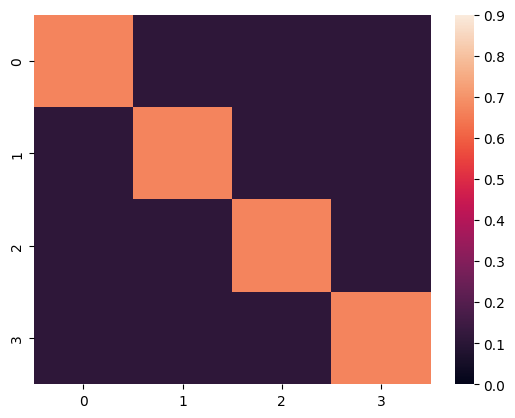

2.4
expected_error_matrix [[1.         0.09071795 0.09071795 0.09071795]
 [0.09071795 1.         0.09071795 0.09071795]
 [0.09071795 0.09071795 1.         0.09071795]
 [0.09071795 0.09071795 0.09071795 1.        ]]
[0.27067261 0.12911383 0.20977728 0.51266295]
[0.3443372  0.16425266 0.26686897 0.65218614]
sum_row_values [0.3443372  0.16425266 0.26686897 0.65218614]
X_new.value [0.7074616 0.7074616 0.7074616 0.7074616]
matrix [[0.7074616  0.06417947 0.06417947 0.06417947]
 [0.06417947 0.7074616  0.06417947 0.06417947]
 [0.06417947 0.06417947 0.7074616  0.06417947]
 [0.06417947 0.06417947 0.06417947 0.7074616 ]]


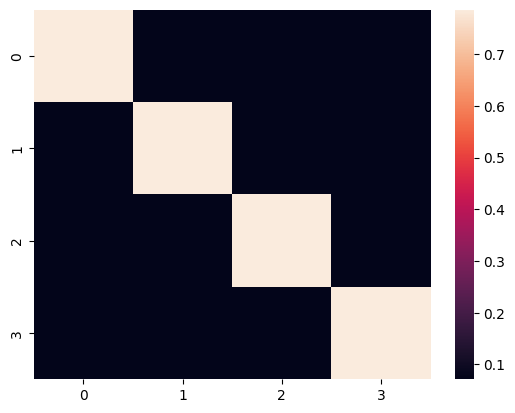

2.4
[[0.78606844 0.07131052 0.07131052 0.07131052]
 [0.07131052 0.78606844 0.07131052 0.07131052]
 [0.07131052 0.07131052 0.78606844 0.07131052]
 [0.07131052 0.07131052 0.07131052 0.78606844]]
[[0.78606844 0.07131052 0.07131052 0.07131052]
 [0.07131052 0.78606844 0.07131052 0.07131052]
 [0.07131052 0.07131052 0.78606844 0.07131052]
 [0.07131052 0.07131052 0.07131052 0.78606844]]


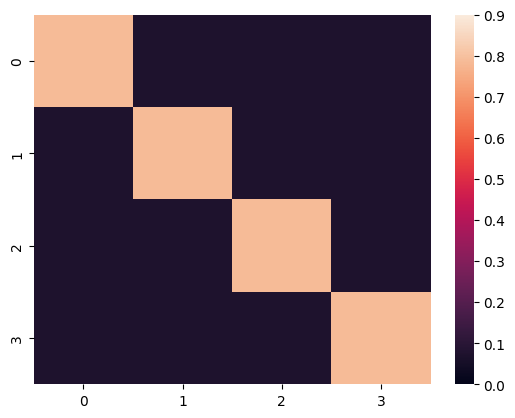

3.0
expected_error_matrix [[1.         0.04978707 0.04978707 0.04978707]
 [0.04978707 1.         0.04978707 0.04978707]
 [0.04978707 0.04978707 1.         0.04978707]
 [0.04978707 0.04978707 0.04978707 1.        ]]
[0.27067261 0.12911383 0.20977728 0.51266295]
[0.3111006  0.14839843 0.24110986 0.5892349 ]
sum_row_values [0.3111006  0.14839843 0.24110986 0.5892349 ]
X_new.value [0.78304366 0.78304366 0.78304366 0.78304366]
matrix [[0.78304366 0.03898545 0.03898545 0.03898545]
 [0.03898545 0.78304366 0.03898545 0.03898545]
 [0.03898545 0.03898545 0.78304366 0.03898545]
 [0.03898545 0.03898545 0.03898545 0.78304366]]


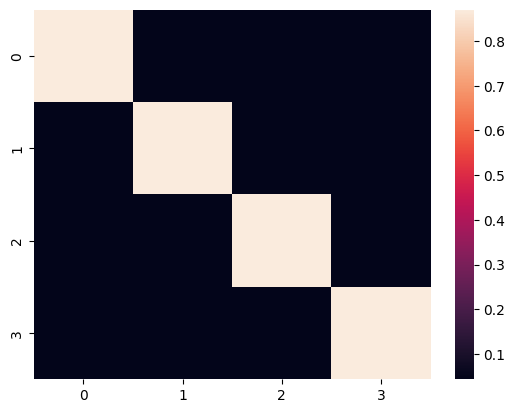

3.0
[[0.87004851 0.04331716 0.04331716 0.04331716]
 [0.04331716 0.87004851 0.04331716 0.04331716]
 [0.04331716 0.04331716 0.87004851 0.04331716]
 [0.04331716 0.04331716 0.04331716 0.87004851]]
[[0.87004851 0.04331716 0.04331716 0.04331716]
 [0.04331716 0.87004851 0.04331716 0.04331716]
 [0.04331716 0.04331716 0.87004851 0.04331716]
 [0.04331716 0.04331716 0.04331716 0.87004851]]


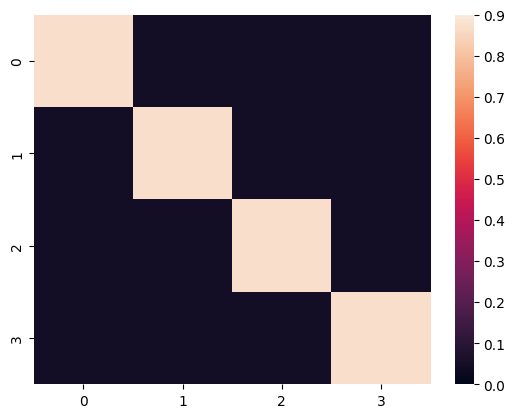

3.5999999999999996
expected_error_matrix [[1.         0.02732372 0.02732372 0.02732372]
 [0.02732372 1.         0.02732372 0.02732372]
 [0.02732372 0.02732372 1.         0.02732372]
 [0.02732372 0.02732372 0.02732372 1.        ]]
[0.27067261 0.12911383 0.20977728 0.51266295]
[0.29285996 0.13969744 0.22697297 0.55468653]
sum_row_values [0.29285996 0.13969744 0.22697297 0.55468653]
X_new.value [0.83181514 0.83181514 0.83181514 0.83181514]
matrix [[0.83181514 0.02272829 0.02272829 0.02272829]
 [0.02272829 0.83181514 0.02272829 0.02272829]
 [0.02272829 0.02272829 0.83181514 0.02272829]
 [0.02272829 0.02272829 0.02272829 0.83181514]]


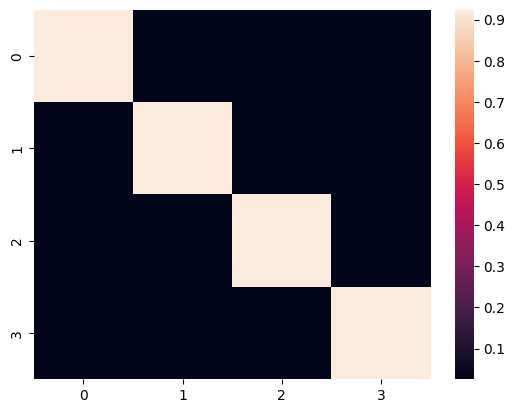

3.5999999999999996
[[0.92423905 0.02525365 0.02525365 0.02525365]
 [0.02525365 0.92423905 0.02525365 0.02525365]
 [0.02525365 0.02525365 0.92423905 0.02525365]
 [0.02525365 0.02525365 0.02525365 0.92423905]]
[[0.92423905 0.02525365 0.02525365 0.02525365]
 [0.02525365 0.92423905 0.02525365 0.02525365]
 [0.02525365 0.02525365 0.92423905 0.02525365]
 [0.02525365 0.02525365 0.02525365 0.92423905]]


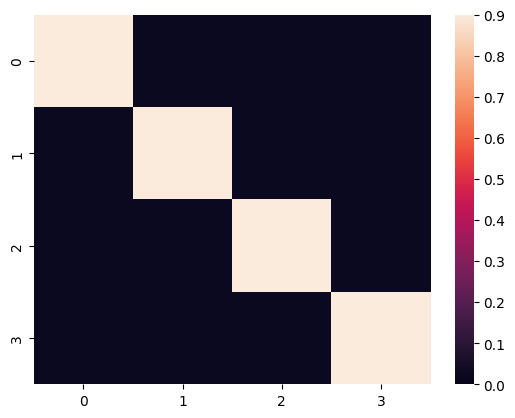

4.2
expected_error_matrix [[1.         0.01499558 0.01499558 0.01499558]
 [0.01499558 1.         0.01499558 0.01499558]
 [0.01499558 0.01499558 1.         0.01499558]
 [0.01499558 0.01499558 0.01499558 1.        ]]
[0.27067261 0.12911383 0.20977728 0.51266295]
[0.28284929 0.13492224 0.21921447 0.53572597]
sum_row_values [0.28284929 0.13492224 0.21921447 0.53572597]
X_new.value [0.86125496 0.86125496 0.86125496 0.86125496]
matrix [[0.86125496 0.01291501 0.01291501 0.01291501]
 [0.01291501 0.86125496 0.01291501 0.01291501]
 [0.01291501 0.01291501 0.86125496 0.01291501]
 [0.01291501 0.01291501 0.01291501 0.86125496]]


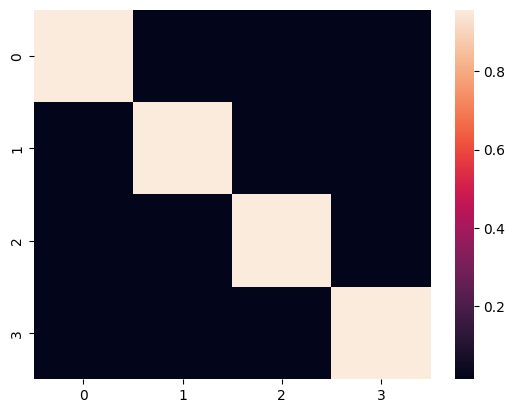

4.2
[[0.95694995 0.01435002 0.01435002 0.01435002]
 [0.01435002 0.95694995 0.01435002 0.01435002]
 [0.01435002 0.01435002 0.95694995 0.01435002]
 [0.01435002 0.01435002 0.01435002 0.95694995]]
[[0.95694995 0.01435002 0.01435002 0.01435002]
 [0.01435002 0.95694995 0.01435002 0.01435002]
 [0.01435002 0.01435002 0.95694995 0.01435002]
 [0.01435002 0.01435002 0.01435002 0.95694995]]


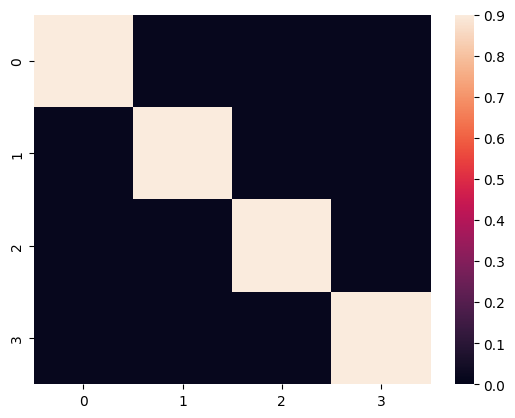

4.8
expected_error_matrix [[1.         0.00822975 0.00822975 0.00822975]
 [0.00822975 1.         0.00822975 0.00822975]
 [0.00822975 0.00822975 1.         0.00822975]
 [0.00822975 0.00822975 0.00822975 1.        ]]
[0.27067261 0.12911383 0.20977728 0.51266295]
[0.27735531 0.13230155 0.21495652 0.5253202 ]
sum_row_values [0.27735531 0.13230155 0.21495652 0.5253202 ]
X_new.value [0.87831507 0.87831507 0.87831507 0.87831507]
matrix [[0.87831507 0.00722831 0.00722831 0.00722831]
 [0.00722831 0.87831507 0.00722831 0.00722831]
 [0.00722831 0.00722831 0.87831507 0.00722831]
 [0.00722831 0.00722831 0.00722831 0.87831507]]


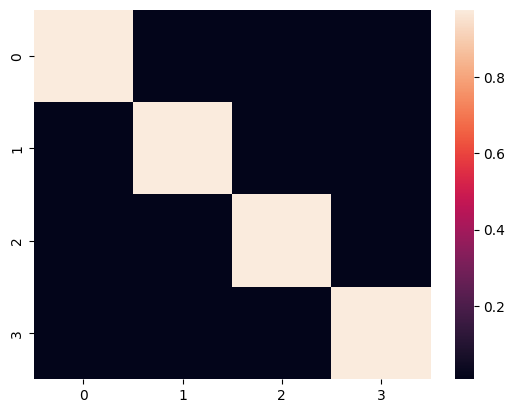

4.8
[[0.97590563 0.00803146 0.00803146 0.00803146]
 [0.00803146 0.97590563 0.00803146 0.00803146]
 [0.00803146 0.00803146 0.97590563 0.00803146]
 [0.00803146 0.00803146 0.00803146 0.97590563]]
[[0.97590563 0.00803146 0.00803146 0.00803146]
 [0.00803146 0.97590563 0.00803146 0.00803146]
 [0.00803146 0.00803146 0.97590563 0.00803146]
 [0.00803146 0.00803146 0.00803146 0.97590563]]


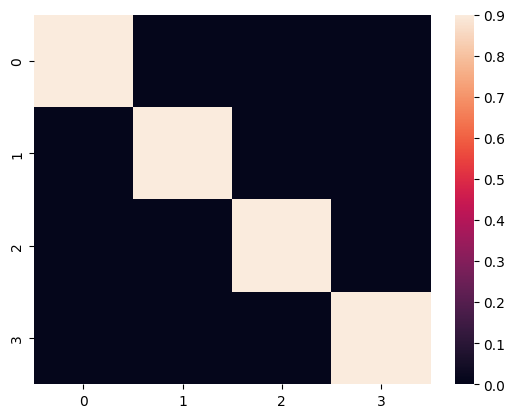

5.3999999999999995
expected_error_matrix [[1.         0.00451658 0.00451658 0.00451658]
 [0.00451658 1.         0.00451658 0.00451658]
 [0.00451658 0.00451658 1.         0.00451658]
 [0.00451658 0.00451658 0.00451658 1.        ]]
[0.27067261 0.12911383 0.20977728 0.51266295]
[0.27434015 0.13086329 0.21261971 0.5196094 ]
sum_row_values [0.27434015 0.13086329 0.21261971 0.5196094 ]
X_new.value [0.88796826 0.88796826 0.88796826 0.88796826]
matrix [[0.88796826 0.00401058 0.00401058 0.00401058]
 [0.00401058 0.88796826 0.00401058 0.00401058]
 [0.00401058 0.00401058 0.88796826 0.00401058]
 [0.00401058 0.00401058 0.00401058 0.88796826]]


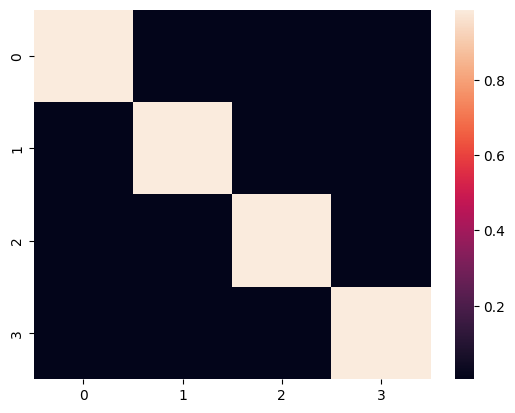

5.3999999999999995
[[0.9866314 0.0044562 0.0044562 0.0044562]
 [0.0044562 0.9866314 0.0044562 0.0044562]
 [0.0044562 0.0044562 0.9866314 0.0044562]
 [0.0044562 0.0044562 0.0044562 0.9866314]]
[[0.9866314 0.0044562 0.0044562 0.0044562]
 [0.0044562 0.9866314 0.0044562 0.0044562]
 [0.0044562 0.0044562 0.9866314 0.0044562]
 [0.0044562 0.0044562 0.0044562 0.9866314]]


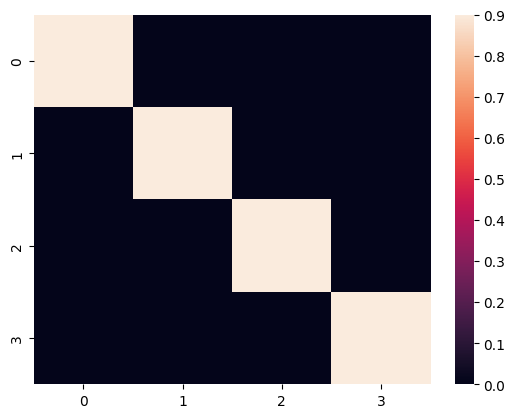

6.0
expected_error_matrix [[1.         0.00247875 0.00247875 0.00247875]
 [0.00247875 1.         0.00247875 0.00247875]
 [0.00247875 0.00247875 1.         0.00247875]
 [0.00247875 0.00247875 0.00247875 1.        ]]
[0.27067261 0.12911383 0.20977728 0.51266295]
[0.2726854  0.13007396 0.21133724 0.51647524]
sum_row_values [0.2726854  0.13007396 0.21133724 0.51647524]
X_new.value [0.89335677 0.89335677 0.89335677 0.89335677]
matrix [[0.89335677 0.00221441 0.00221441 0.00221441]
 [0.00221441 0.89335677 0.00221441 0.00221441]
 [0.00221441 0.00221441 0.89335677 0.00221441]
 [0.00221441 0.00221441 0.00221441 0.89335677]]


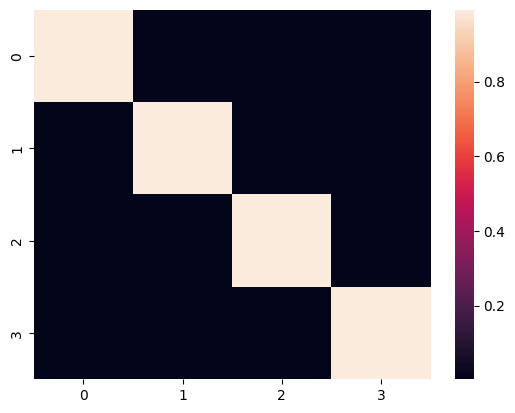

6.0
[[0.99261863 0.00246046 0.00246046 0.00246046]
 [0.00246046 0.99261863 0.00246046 0.00246046]
 [0.00246046 0.00246046 0.99261863 0.00246046]
 [0.00246046 0.00246046 0.00246046 0.99261863]]
[[0.99261863 0.00246046 0.00246046 0.00246046]
 [0.00246046 0.99261863 0.00246046 0.00246046]
 [0.00246046 0.00246046 0.99261863 0.00246046]
 [0.00246046 0.00246046 0.00246046 0.99261863]]


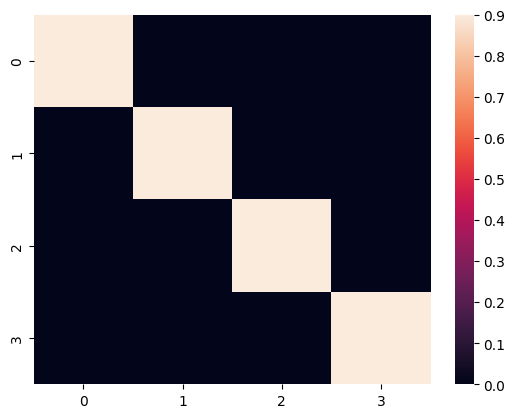

6.6
expected_error_matrix [[1.         0.00136037 0.00136037 0.00136037]
 [0.00136037 1.         0.00136037 0.00136037]
 [0.00136037 0.00136037 1.         0.00136037]
 [0.00136037 0.00136037 0.00136037 1.        ]]
[0.27067261 0.12911383 0.20977728 0.51266295]
[0.27177725 0.12964076 0.2106334  0.51475518]
sum_row_values [0.27177725 0.12964076 0.2106334  0.51475518]
X_new.value [0.89634194 0.89634194 0.89634194 0.89634194]
matrix [[0.89634194 0.00121935 0.00121935 0.00121935]
 [0.00121935 0.89634194 0.00121935 0.00121935]
 [0.00121935 0.00121935 0.89634194 0.00121935]
 [0.00121935 0.00121935 0.00121935 0.89634194]]


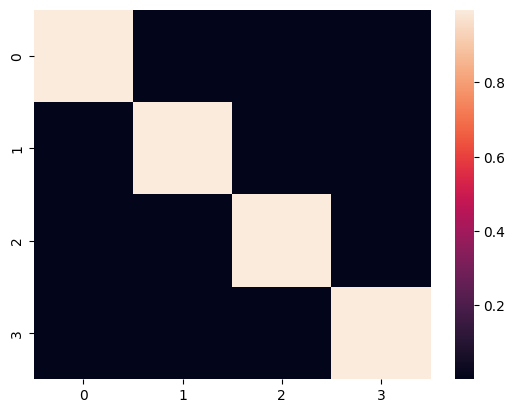

6.6
[[0.99593548 0.00135484 0.00135484 0.00135484]
 [0.00135484 0.99593548 0.00135484 0.00135484]
 [0.00135484 0.00135484 0.99593548 0.00135484]
 [0.00135484 0.00135484 0.00135484 0.99593548]]
[[0.99593548 0.00135484 0.00135484 0.00135484]
 [0.00135484 0.99593548 0.00135484 0.00135484]
 [0.00135484 0.00135484 0.99593548 0.00135484]
 [0.00135484 0.00135484 0.00135484 0.99593548]]


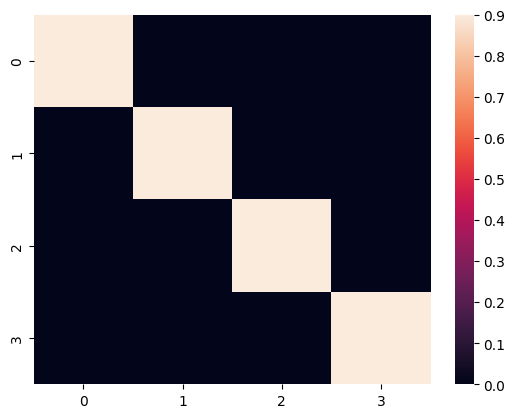

7.199999999999999
expected_error_matrix [[1.00000000e+00 7.46585808e-04 7.46585808e-04 7.46585808e-04]
 [7.46585808e-04 1.00000000e+00 7.46585808e-04 7.46585808e-04]
 [7.46585808e-04 7.46585808e-04 1.00000000e+00 7.46585808e-04]
 [7.46585808e-04 7.46585808e-04 7.46585808e-04 1.00000000e+00]]
[0.27067261 0.12911383 0.20977728 0.51266295]
[0.27127885 0.12940302 0.21024713 0.51381119]
sum_row_values [0.27127885 0.12940302 0.21024713 0.51381119]
X_new.value [0.89798872 0.89798872 0.89798872 0.89798872]
matrix [[8.97988723e-01 6.70425637e-04 6.70425637e-04 6.70425637e-04]
 [6.70425637e-04 8.97988723e-01 6.70425637e-04 6.70425637e-04]
 [6.70425637e-04 6.70425637e-04 8.97988723e-01 6.70425637e-04]
 [6.70425637e-04 6.70425637e-04 6.70425637e-04 8.97988723e-01]]


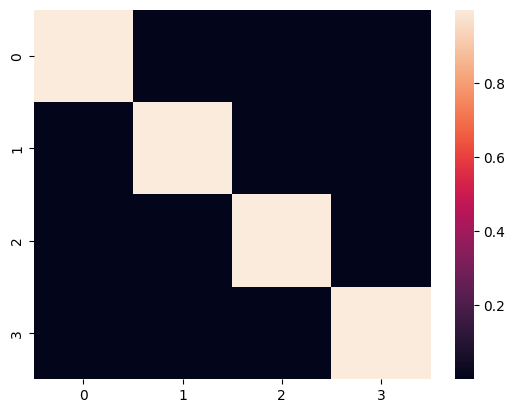

7.199999999999999
[[9.97765248e-01 7.44917374e-04 7.44917374e-04 7.44917374e-04]
 [7.44917374e-04 9.97765248e-01 7.44917374e-04 7.44917374e-04]
 [7.44917374e-04 7.44917374e-04 9.97765248e-01 7.44917374e-04]
 [7.44917374e-04 7.44917374e-04 7.44917374e-04 9.97765248e-01]]
[[9.97765248e-01 7.44917374e-04 7.44917374e-04 7.44917374e-04]
 [7.44917374e-04 9.97765248e-01 7.44917374e-04 7.44917374e-04]
 [7.44917374e-04 7.44917374e-04 9.97765248e-01 7.44917374e-04]
 [7.44917374e-04 7.44917374e-04 7.44917374e-04 9.97765248e-01]]


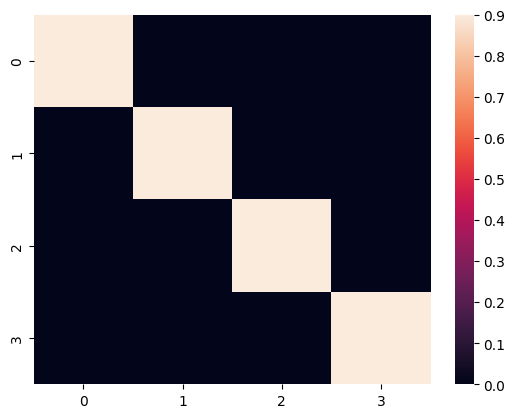

7.8
expected_error_matrix [[1.00000000e+00 4.09734979e-04 4.09734979e-04 4.09734979e-04]
 [4.09734979e-04 1.00000000e+00 4.09734979e-04 4.09734979e-04]
 [4.09734979e-04 4.09734979e-04 1.00000000e+00 4.09734979e-04]
 [4.09734979e-04 4.09734979e-04 4.09734979e-04 1.00000000e+00]]
[0.27067261 0.12911383 0.20977728 0.51266295]
[0.27100532 0.12927254 0.21003514 0.51329311]
sum_row_values [0.27100532 0.12927254 0.21003514 0.51329311]
X_new.value [0.89889507 0.89889507 0.89889507 0.89889507]
matrix [[8.98895074e-01 3.68308754e-04 3.68308754e-04 3.68308754e-04]
 [3.68308754e-04 8.98895074e-01 3.68308754e-04 3.68308754e-04]
 [3.68308754e-04 3.68308754e-04 8.98895074e-01 3.68308754e-04]
 [3.68308754e-04 3.68308754e-04 3.68308754e-04 8.98895074e-01]]


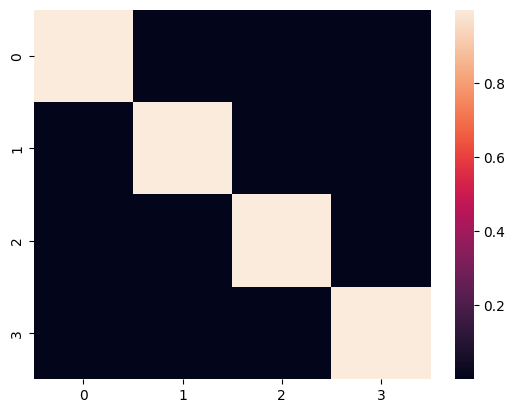

7.8
[[9.98772304e-01 4.09231949e-04 4.09231949e-04 4.09231949e-04]
 [4.09231949e-04 9.98772304e-01 4.09231949e-04 4.09231949e-04]
 [4.09231949e-04 4.09231949e-04 9.98772304e-01 4.09231949e-04]
 [4.09231949e-04 4.09231949e-04 4.09231949e-04 9.98772304e-01]]
[[9.98772304e-01 4.09231949e-04 4.09231949e-04 4.09231949e-04]
 [4.09231949e-04 9.98772304e-01 4.09231949e-04 4.09231949e-04]
 [4.09231949e-04 4.09231949e-04 9.98772304e-01 4.09231949e-04]
 [4.09231949e-04 4.09231949e-04 4.09231949e-04 9.98772304e-01]]


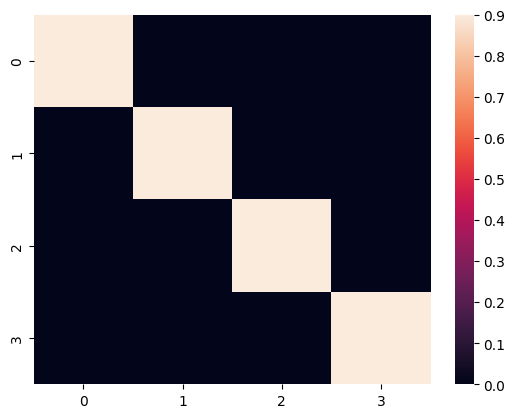

8.4
expected_error_matrix [[1.00000000e+00 2.24867324e-04 2.24867324e-04 2.24867324e-04]
 [2.24867324e-04 1.00000000e+00 2.24867324e-04 2.24867324e-04]
 [2.24867324e-04 2.24867324e-04 1.00000000e+00 2.24867324e-04]
 [2.24867324e-04 2.24867324e-04 2.24867324e-04 1.00000000e+00]]
[0.27067261 0.12911383 0.20977728 0.51266295]
[0.27085521 0.12920093 0.20991879 0.51300879]
sum_row_values [0.27085521 0.12920093 0.20991879 0.51300879]
X_new.value [0.89939327 0.89939327 0.89939327 0.89939327]
matrix [[8.99393268e-01 2.02244157e-04 2.02244157e-04 2.02244157e-04]
 [2.02244157e-04 8.99393268e-01 2.02244157e-04 2.02244157e-04]
 [2.02244157e-04 2.02244157e-04 8.99393268e-01 2.02244157e-04]
 [2.02244157e-04 2.02244157e-04 2.02244157e-04 8.99393268e-01]]


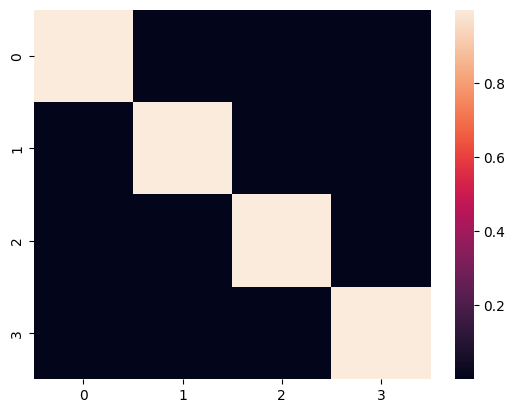

8.4
[[9.99325853e-01 2.24715731e-04 2.24715731e-04 2.24715731e-04]
 [2.24715731e-04 9.99325853e-01 2.24715731e-04 2.24715731e-04]
 [2.24715731e-04 2.24715731e-04 9.99325853e-01 2.24715731e-04]
 [2.24715731e-04 2.24715731e-04 2.24715731e-04 9.99325853e-01]]
[[9.99325853e-01 2.24715731e-04 2.24715731e-04 2.24715731e-04]
 [2.24715730e-04 9.99325853e-01 2.24715730e-04 2.24715730e-04]
 [2.24715731e-04 2.24715731e-04 9.99325853e-01 2.24715730e-04]
 [2.24715731e-04 2.24715731e-04 2.24715731e-04 9.99325853e-01]]


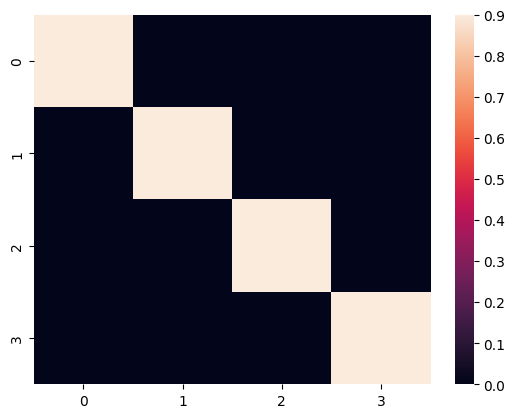

9.0
expected_error_matrix [[1.00000000e+00 1.23409804e-04 1.23409804e-04 1.23409804e-04]
 [1.23409804e-04 1.00000000e+00 1.23409804e-04 1.23409804e-04]
 [1.23409804e-04 1.23409804e-04 1.00000000e+00 1.23409804e-04]
 [1.23409804e-04 1.23409804e-04 1.23409804e-04 1.00000000e+00]]
[0.27067261 0.12911383 0.20977728 0.51266295]
[0.27077282 0.12916163 0.20985494 0.51285275]
sum_row_values [0.27077282 0.12916163 0.20985494 0.51285275]
X_new.value [0.89966692 0.89966692 0.89966692 0.89966692]
matrix [[8.99666917e-01 1.11027718e-04 1.11027718e-04 1.11027718e-04]
 [1.11027718e-04 8.99666917e-01 1.11027718e-04 1.11027718e-04]
 [1.11027718e-04 1.11027718e-04 8.99666917e-01 1.11027718e-04]
 [1.11027718e-04 1.11027718e-04 1.11027718e-04 8.99666917e-01]]


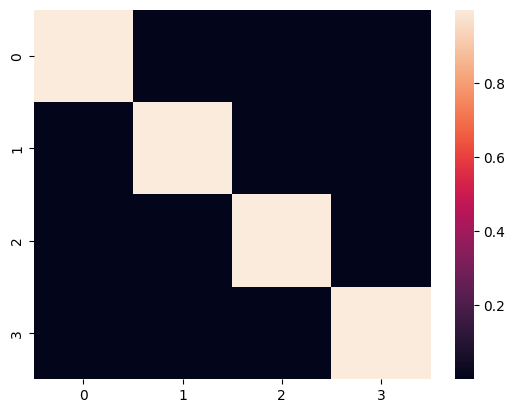

9.0
[[9.99629908e-01 1.23364131e-04 1.23364131e-04 1.23364131e-04]
 [1.23364131e-04 9.99629908e-01 1.23364131e-04 1.23364131e-04]
 [1.23364131e-04 1.23364131e-04 9.99629908e-01 1.23364131e-04]
 [1.23364131e-04 1.23364131e-04 1.23364131e-04 9.99629908e-01]]
[[9.99629908e-01 1.23364131e-04 1.23364131e-04 1.23364131e-04]
 [1.23364131e-04 9.99629908e-01 1.23364131e-04 1.23364131e-04]
 [1.23364131e-04 1.23364131e-04 9.99629908e-01 1.23364131e-04]
 [1.23364131e-04 1.23364131e-04 1.23364131e-04 9.99629908e-01]]


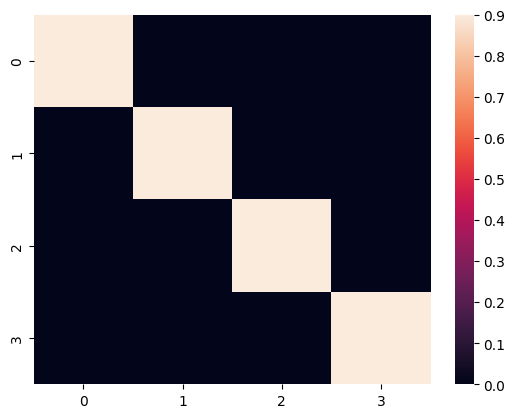

9.6
expected_error_matrix [[1.00000000e+00 6.77287365e-05 6.77287365e-05 6.77287365e-05]
 [6.77287365e-05 1.00000000e+00 6.77287365e-05 6.77287365e-05]
 [6.77287365e-05 6.77287365e-05 1.00000000e+00 6.77287365e-05]
 [6.77287365e-05 6.77287365e-05 6.77287365e-05 1.00000000e+00]]
[0.27067261 0.12911383 0.20977728 0.51266295]
[0.27072761 0.12914007 0.2098199  0.51276711]
sum_row_values [0.27072761 0.12914007 0.2098199  0.51276711]
X_new.value [0.89981717 0.89981717 0.89981717 0.89981717]
matrix [[8.9981717e-01 6.0943480e-05 6.0943480e-05 6.0943480e-05]
 [6.0943480e-05 8.9981717e-01 6.0943480e-05 6.0943480e-05]
 [6.0943480e-05 6.0943480e-05 8.9981717e-01 6.0943480e-05]
 [6.0943480e-05 6.0943480e-05 6.0943480e-05 8.9981717e-01]]


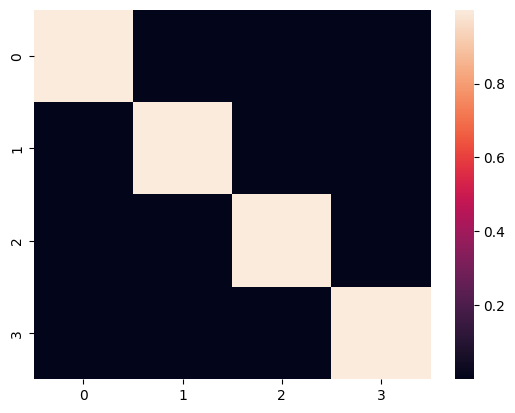

9.6
[[9.99796855e-01 6.77149777e-05 6.77149777e-05 6.77149777e-05]
 [6.77149777e-05 9.99796855e-01 6.77149777e-05 6.77149777e-05]
 [6.77149777e-05 6.77149777e-05 9.99796855e-01 6.77149777e-05]
 [6.77149777e-05 6.77149777e-05 6.77149777e-05 9.99796855e-01]]
[[9.99796855e-01 6.77149777e-05 6.77149777e-05 6.77149777e-05]
 [6.77149777e-05 9.99796855e-01 6.77149777e-05 6.77149777e-05]
 [6.77149777e-05 6.77149777e-05 9.99796855e-01 6.77149777e-05]
 [6.77149777e-05 6.77149777e-05 6.77149777e-05 9.99796855e-01]]


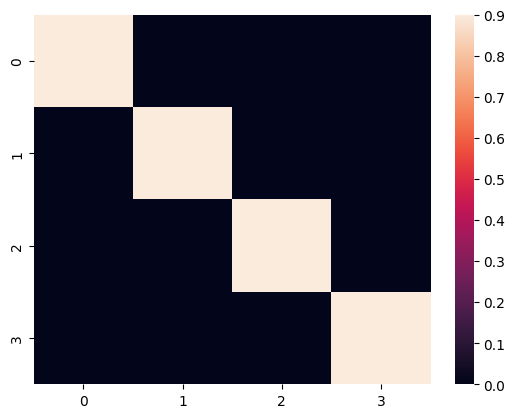

10.2
expected_error_matrix [[1.00000000e+00 3.71703187e-05 3.71703187e-05 3.71703187e-05]
 [3.71703187e-05 1.00000000e+00 3.71703187e-05 3.71703187e-05]
 [3.71703187e-05 3.71703187e-05 1.00000000e+00 3.71703187e-05]
 [3.71703187e-05 3.71703187e-05 3.71703187e-05 1.00000000e+00]]
[0.27067261 0.12911383 0.20977728 0.51266295]
[0.27070279 0.12912823 0.20980067 0.51272011]
sum_row_values [0.27070279 0.12912823 0.20980067 0.51272011]
X_new.value [0.89989965 0.89989965 0.89989965 0.89989965]
matrix [[8.99899651e-01 3.34495568e-05 3.34495568e-05 3.34495568e-05]
 [3.34495568e-05 8.99899651e-01 3.34495568e-05 3.34495568e-05]
 [3.34495568e-05 3.34495568e-05 8.99899651e-01 3.34495568e-05]
 [3.34495568e-05 3.34495568e-05 3.34495568e-05 8.99899651e-01]]


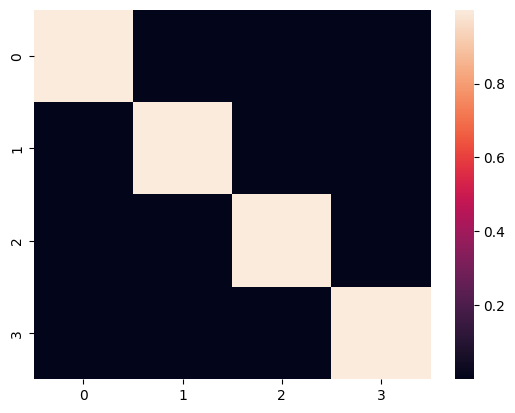

10.2
[[9.99888501e-01 3.71661742e-05 3.71661742e-05 3.71661742e-05]
 [3.71661742e-05 9.99888501e-01 3.71661742e-05 3.71661742e-05]
 [3.71661742e-05 3.71661742e-05 9.99888501e-01 3.71661742e-05]
 [3.71661742e-05 3.71661742e-05 3.71661742e-05 9.99888501e-01]]
[[9.99888501e-01 3.71661743e-05 3.71661742e-05 3.71661742e-05]
 [3.71661742e-05 9.99888501e-01 3.71661742e-05 3.71661742e-05]
 [3.71661742e-05 3.71661742e-05 9.99888501e-01 3.71661742e-05]
 [3.71661742e-05 3.71661743e-05 3.71661742e-05 9.99888501e-01]]


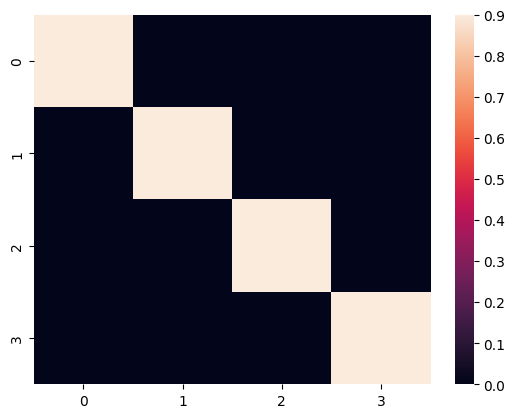

10.799999999999999
expected_error_matrix [[1.00000000e+00 2.03995034e-05 2.03995034e-05 2.03995034e-05]
 [2.03995034e-05 1.00000000e+00 2.03995034e-05 2.03995034e-05]
 [2.03995034e-05 2.03995034e-05 1.00000000e+00 2.03995034e-05]
 [2.03995034e-05 2.03995034e-05 2.03995034e-05 1.00000000e+00]]
[0.27067261 0.12911383 0.20977728 0.51266295]
[0.27068917 0.12912173 0.20979012 0.51269432]
sum_row_values [0.27068917 0.12912173 0.20979012 0.51269432]
X_new.value [0.89994492 0.89994492 0.89994492 0.89994492]
matrix [[8.99944925e-01 1.83584296e-05 1.83584296e-05 1.83584296e-05]
 [1.83584296e-05 8.99944925e-01 1.83584296e-05 1.83584296e-05]
 [1.83584296e-05 1.83584296e-05 8.99944925e-01 1.83584296e-05]
 [1.83584296e-05 1.83584296e-05 1.83584296e-05 8.99944925e-01]]


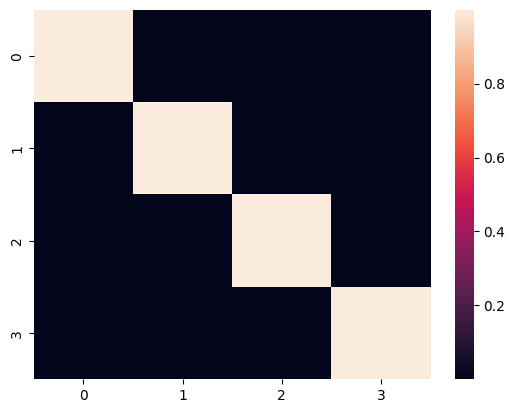

10.799999999999999
[[9.99938805e-01 2.03982551e-05 2.03982551e-05 2.03982551e-05]
 [2.03982551e-05 9.99938805e-01 2.03982551e-05 2.03982551e-05]
 [2.03982551e-05 2.03982551e-05 9.99938805e-01 2.03982551e-05]
 [2.03982551e-05 2.03982551e-05 2.03982551e-05 9.99938805e-01]]
[[9.99938805e-01 2.03982551e-05 2.03982551e-05 2.03982551e-05]
 [2.03982551e-05 9.99938805e-01 2.03982551e-05 2.03982551e-05]
 [2.03982551e-05 2.03982551e-05 9.99938805e-01 2.03982551e-05]
 [2.03982551e-05 2.03982551e-05 2.03982551e-05 9.99938805e-01]]


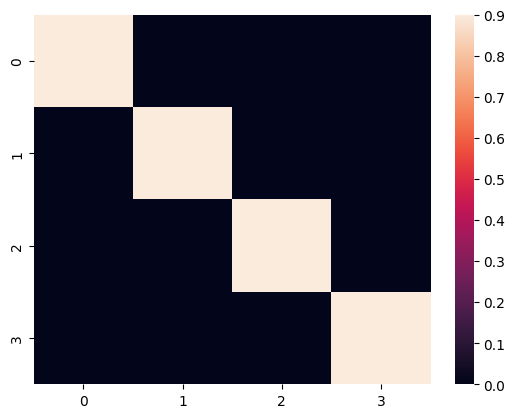

11.4
expected_error_matrix [[1.00000000e+00 1.11954848e-05 1.11954848e-05 1.11954848e-05]
 [1.11954848e-05 1.00000000e+00 1.11954848e-05 1.11954848e-05]
 [1.11954848e-05 1.11954848e-05 1.00000000e+00 1.11954848e-05]
 [1.11954848e-05 1.11954848e-05 1.11954848e-05 1.00000000e+00]]
[0.27067261 0.12911383 0.20977728 0.51266295]
[0.2706817  0.12911817 0.20978432 0.51268016]
sum_row_values [0.2706817  0.12911817 0.20978432 0.51268016]
X_new.value [0.89996977 0.89996977 0.89996977 0.89996977]
matrix [[8.99969773e-01 1.00755980e-05 1.00755980e-05 1.00755980e-05]
 [1.00755980e-05 8.99969773e-01 1.00755980e-05 1.00755980e-05]
 [1.00755980e-05 1.00755980e-05 8.99969773e-01 1.00755980e-05]
 [1.00755980e-05 1.00755980e-05 1.00755980e-05 8.99969773e-01]]


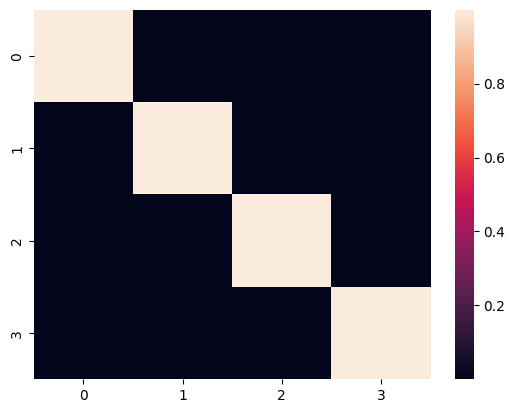

11.4
[[9.99966415e-01 1.11951088e-05 1.11951088e-05 1.11951088e-05]
 [1.11951088e-05 9.99966415e-01 1.11951088e-05 1.11951088e-05]
 [1.11951088e-05 1.11951088e-05 9.99966415e-01 1.11951088e-05]
 [1.11951088e-05 1.11951088e-05 1.11951088e-05 9.99966415e-01]]
[[9.99966415e-01 1.11951088e-05 1.11951088e-05 1.11951088e-05]
 [1.11951088e-05 9.99966415e-01 1.11951088e-05 1.11951088e-05]
 [1.11951088e-05 1.11951088e-05 9.99966415e-01 1.11951088e-05]
 [1.11951088e-05 1.11951088e-05 1.11951088e-05 9.99966415e-01]]


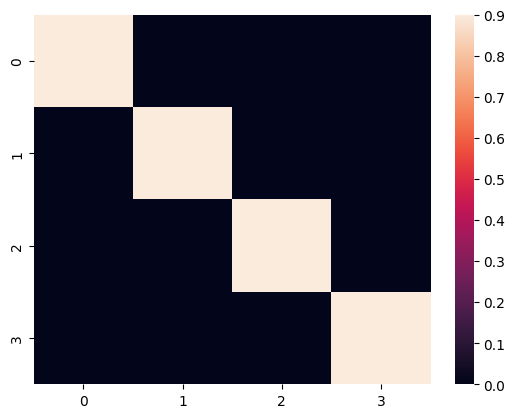

In [4]:
eps_array = np.arange(20)*0.6

for eps in eps_array:
    rr_mechanism_ = rr_mechanism.get_mechanism(eps=eps)
    try:
        optimal_mechanim_ = optimal_rr_mechanism.get_mechanism(eps=eps)
    except:
        continue
    

    sns.heatmap(rr_mechanism_)
    plt.show()

    print(eps)
    print(rr_mechanism_)
    print(optimal_mechanim_)

    sns.heatmap(optimal_mechanim_, vmin=0.0, vmax=0.9)
    plt.show()
        